<a href="https://colab.research.google.com/github/brianmanderson/Image_Prediction/blob/main/Simple_Model_phantom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2019 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# pix2pix: Image-to-image translation with a conditional GAN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/pix2pix"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/pix2pix.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/pix2pix.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/generative/pix2pix.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This Google Colab Notebook heavily buroows from the pix2pix example. 
How to build and train a conditional generative adversarial network (cGAN) called pix2pix that learns a mapping from input images to output images, as described in [Image-to-image translation with conditional adversarial networks](https://arxiv.org/abs/1611.07004) by Isola et al. (2017). pix2pix is not application specific—it can be applied to a wide range of tasks, including synthesizing photos from label maps, generating colorized photos from black and white images, turning Google Maps photos into aerial images, and even transforming sketches into photos.

In the pix2pix cGAN, you condition on input images and generate corresponding output images. cGANs were first proposed in [Conditional Generative Adversarial Nets](https://arxiv.org/abs/1411.1784) (Mirza and Osindero, 2014)

The architecture of your network will contain:

- A generator with a [U-Net]([U-Net](https://arxiv.org/abs/1505.04597))-based architecture.
- A discriminator represented by a convolutional PatchGAN classifier (proposed in the [pix2pix paper](https://arxiv.org/abs/1611.07004)).

Note that each epoch can take around 15 seconds on a single V100 GPU.



## Import TensorFlow and other libraries

In [ ]:
import tensorflow as tf

import os
import sys 
import pathlib
import time
import datetime
import numpy as np
from matplotlib import pyplot as plt
from IPython import display
import tensorflow.experimental.numpy as tnp

In [ ]:
running_local = False
try:
    from google.colab import drive
    drive.mount('/content/drive')
    nb_path = '/content/notebooks'
    os.symlink('/content/drive/MyDrive/Colab Notebooks', nb_path)
    sys.path.insert(0, nb_path)  # or append(nb_path)
except:
    running_local = True
    print("Running locally")

Mounted at /content/drive


In [ ]:
os.listdir('/content/drive/My Drive/data')

['jpeg',
 'tfrecords_removeone',
 'tfrecords_one',
 'old',
 'fold1',
 'fold2',
 'fold3',
 'fold4',
 'fold5',
 'norm_jpeg',
 'csv',
 'jpeg_old',
 'phantom_train',
 'phantom_valid',
 'phantom_large',
 'phantom_large_out']

Line to install pymedphys which has a gamma function. Libaray was saved to Google drive and is commented out.

In [ ]:
#!pip install --target=$nb_path pymedphys

In [ ]:
!pip install SimpleITK
!pip install pymedphys
!pip install PlotScrollNumpyArrays

     |████████████████████████████████| 48.4 MB 1.5 MB/s 
     |████████████████████████████████| 1.8 MB 4.1 MB/s 
     |████████████████████████████████| 793 kB 43.3 MB/s 
     |████████████████████████████████| 381 kB 53.6 MB/s 
  Attempting uninstall: prompt-toolkit
    Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successfully uninstalled prompt-toolkit-1.0.18
  Attempting uninstall: ipython
    Found existing installation: ipython 5.5.0
    Uninstalling ipython-5.5.0:
      Successfully uninstalled ipython-5.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-console 5.2.0 requires prompt-toolkit<2.0.0,>=1.0.0, but you have prompt-toolkit 3.0.29 which is incompatible.
google-colab 1.0.0 requires ipython~=5.5.0, but you have ipython 7.32.0 which is incompatible.


In [ ]:
import SimpleITK as sitk
import pymedphys

In [ ]:
!git clone --recurse-submodules -j8 https://github.com/brianmanderson/Data_Generators

Cloning into 'Data_Generators'...
remote: Enumerating objects: 1092, done.
remote: Counting objects: 100% (86/86), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 1092 (delta 43), reused 65 (delta 24), pack-reused 1006
Receiving objects: 100% (1092/1092), 524.35 KiB | 3.08 MiB/s, done.
Resolving deltas: 100% (689/689), done.
Submodule 'Image_Processors_Module' (https://github.com/brianmanderson/Image_Processors_Module.git) registered for path 'Image_Processors_Module'
Cloning into '/content/Data_Generators/Image_Processors_Module'...
remote: Enumerating objects: 1205, done.        
remote: Total 1205 (delta 0), reused 0 (delta 0), pack-reused 1205        
Receiving objects: 100% (1205/1205), 248.38 KiB | 1.47 MiB/s, done.
Resolving deltas: 100% (773/773), done.
Submodule path 'Image_Processors_Module': checked out 'f91603a2bedcc15981db54709e4c6d83c997f595'


In [ ]:
from Data_Generators.TFRecord_to_Dataset_Generator import DataGeneratorClass
from Data_Generators.Image_Processors_Module.src.Processors.TFDataSets import ConstantProcessors as CProcessors,\
    RelativeProcessors as RProcessors

Pull a sample image.   There are 4 images in 1 that need to be reformatted. From left to right, ray trace projection of CBCT. Fluence Map, PDOS and RTImage

In [ ]:
def return_generator(records_paths):
    generator = DataGeneratorClass(record_paths=records_paths)
    all_keys = ('pdos_array', 'drr_array', 'half_drr_array', 'fluence_array')
    base_processors = [
                       CProcessors.Squeeze(image_keys=all_keys),
                       CProcessors.ExpandDimension(axis=-1,
                                                   image_keys=('pdos_array',
                                                               'drr_array',
                                                               'half_drr_array',
                                                               'fluence_array')),
        # RProcessors.NormalizeBasedOnOther(guiding_keys=('pdos_array', 'pdos_array'),
        #                                   changing_keys=('fluence_array', 'pdos_array'),
        #                                   reference_method=('reduce_max', 'reduce_max'),
        #                                   changing_methods=('divide', 'divide')),
                      CProcessors.MultiplyImagesByConstant(keys=('pdos_array',
                                                                 'fluence_array',
                                                                 'drr_array',
                                                                 'half_drr_array'),
                                                           values=(1/3.448,
                                                                   1/2.226,
                                                                   1/325,
                                                                   1/175)),
                       CProcessors.CombineKeys(axis=-1,
                                               image_keys=('pdos_array',
                                                           'drr_array',
                                                           'half_drr_array'),
                                               output_key='combined'),
                       CProcessors.ReturnOutputs(input_keys=('combined',),
                                                 output_keys=('fluence_array',)),
                       {'shuffle': len(generator) // 3},
                       {'batch': 1}, {'repeat'}
                       ]
    generator.compile_data_set(image_processors=base_processors, debug=False)
    return generator

In [ ]:
# data_generators = {}

# data_generators[1] = return_generator('/content/drive/My Drive/data/tfrecords_removeone')
# data_generators[2] = return_generator('/content/drive/My Drive/data/tfrecords_one')

In [ ]:
# data_generators = {}
# for i in range(1,6):
#   data_generators[i] = return_generator('/content/drive/My Drive/data/fold{}'.format(i))

In [ ]:
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1
# Each image is 256x256 in size
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [ ]:
def load_data_from_generator(generator):
  data = {'input' : [], 'rtimg' : []}
  iterator = iter(generator.data_set)
  for _ in range(len(generator)):
    x, y = next(iterator)
    data['input'].append(x[0][0])
    data['rtimg'].append(y[0][0])
  return data

# Return a train and validation dataset based on which fold you want to exclude

In [ ]:
def return_datasets(data_generators):
  all_datasets = {}
  for i in data_generators.keys():
    generator = data_generators[i]
    all_datasets[i] = tf.data.Dataset.from_tensor_slices((load_data_from_generator(generator)))
  return all_datasets

def return_fold_datasets(data_generators, batch_size=1):
  all_datasets = return_datasets(data_generators)

  train_dataset = all_datasets['train']
  train_dataset = train_dataset.shuffle(len(train_dataset))
  train_dataset = train_dataset.batch(batch_size)
  
  valid_dataset = all_datasets['validation']
  valid_dataset = valid_dataset.shuffle(len(valid_dataset))
  valid_dataset = valid_dataset.batch(1)
  return train_dataset, valid_dataset

In [ ]:
def return_generators(excluded_fold=2):
  data_generators = {}
  train_folder_names = []
  val_folder_names = []
  # for i in range(1,6):
  #   folder_name = '/content/drive/My Drive/data/fold{}'.format(i)
  #   if i != excluded_fold:
  #     train_folder_names.append(folder_name)
  #   else:
  #     val_folder_names.append(folder_name)
  #train_folder_names = ['/content/drive/My Drive/data/phantom_train']
  #val_folder_names = ['/content/drive/My Drive/data/phantom_valid']
  train_folder_names = ['/content/drive/My Drive/data/phantom_large']
  val_folder_names = ['/content/drive/My Drive/data/phantom_large_out']
  data_generators['train'] = return_generator(records_paths= train_folder_names)
  data_generators['validation'] = return_generator(records_paths=val_folder_names)
  return data_generators

In [ ]:
data_generators = return_generators(excluded_fold=1)
train_dataset, valid_dataset = return_fold_datasets(data_generators, batch_size=1)

Be careful..Resize with crop/pad can severely slow down data retrieval, best to do this and cache
{'shuffle': 10}
{'batch': 1}
{'repeat'}
Be careful..Resize with crop/pad can severely slow down data retrieval, best to do this and cache
{'shuffle': 2}
{'batch': 1}
{'repeat'}


In [ ]:
train_dataset.take(1)

<TakeDataset element_spec={'input': TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), 'rtimg': TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None)}>

In [ ]:
# train_dataset, valid_dataset = return_fold_datasets(data_generators,2)
# print(len(train_dataset))
# print(len(valid_dataset))

tf.Tensor([256 256   1], shape=(3,), dtype=int32)


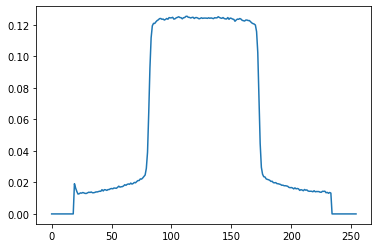

In [ ]:
if not running_local:
  for val in valid_dataset.take(1):
    inp = val['rtimg']
    inp1 = tf.squeeze(inp,axis=0)
    vec = inp1[1:256,128]
    plt.plot(vec)
    print(tf.shape(inp1))

In [ ]:
def getinput(input_image,chan):
    slice_image = input_image[:,:,chan]
    slice_image = tf.cast(slice_image, tf.float32)
    return slice_image

tf.Tensor([256 256], shape=(2,), dtype=int32)


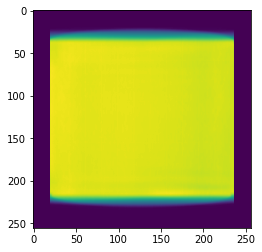

In [ ]:
slicen = 2
for val in valid_dataset.take(1):
  inp = tf.squeeze(val['input'],axis=0)
  #print(tf.shape(inp))
  img = getinput(inp,slicen)
  print(tf.shape(img))


plt.figure()
#plt.imshow(tf.squeeze(img, axis=-1))
plt.imshow(inp)
plt.imshow(img)

tf.Tensor([  1 256 256   1], shape=(4,), dtype=int32)
tf.Tensor([256 256], shape=(2,), dtype=int32)


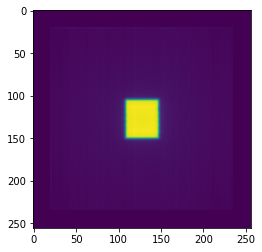

In [ ]:
for val in valid_dataset.take(1):
  img = val['rtimg']
  print(tf.shape(img))

img = tf.squeeze(img, axis=0)
img = tf.squeeze(img, axis=-1)
#img = tf.cast(img, tf.float32)
print(tf.shape(img))
#plt.figure()
#plt.imshow(tf.squeeze(img, axis=-1))
plt.imshow(img)

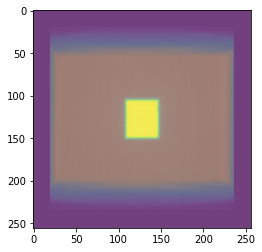

In [ ]:
slicen =1
for val in valid_dataset.take(1):
  inp = tf.squeeze(val['input'],axis=0)
  img1 = getinput(inp,slicen)
  img2 = val['rtimg']
  img2 = tf.squeeze(img2, axis=0)
  #print(tf.shape(img))

#img2 = tf.cast(img2, tf.float32)
plt.figure()
plt.imshow(img1,alpha=0.5)
plt.imshow(tf.squeeze(img2, axis=-1),alpha=0.5)

As described in the [pix2pix paper](https://arxiv.org/abs/1611.07004), you need to apply random jittering and mirroring to preprocess the training set.

Define functions that:

1. Randomly flip the image horizontally i.e. left to right (random mirroring).
2. Normalize the images to the `[-1, 1]` range. 

In [ ]:
OUTPUT_CHANNELS = 1

In [ ]:
def downsample(filters, size, apply_batchnorm=True, max_pool=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  strides = 1
  if not max_pool:
    strides = 2
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=strides, padding='same',
                             kernel_initializer=initializer, use_bias=False))
  if max_pool:
    result.add(tf.keras.layers.MaxPool2D(pool_size=(4,4)))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())
  return result

Define the upsampler (decoder):

In [ ]:
def upsample(filters, size, apply_dropout=False, max_pooled=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  if not max_pooled:
    result.add(
      tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))
  else:
    result.add(tf.keras.layers.UpSampling2D(size=(4, 4), interpolation='bilinear'))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [ ]:
def GeneratorP():
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

Define the generator with the downsampler and the upsampler:

In [ ]:
def GeneratorU(size=4, layers=3, filters_start=4, double_layers=4):
  """
  default values creates the original generator, filters double from start
  to a max after the number of 'double layers'
  Size is the kernel size
  Layers is the number of layers
  """
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])
  filters_list = []
  for _ in range(double_layers):
    filters_list.append(filters_start)
    filters_start *= 2
  up_filters = []
  batchnorm = False
  down_stack = []
  for _ in range(layers):
    if filters_list:
      filters = filters_list.pop(0)
    up_filters.append(filters)
    print(filters)
    layer = downsample(filters, size, batchnorm)
    down_stack.append(layer)
    batchnorm = True
  if filters_list:
    filters = filters_list.pop(0)
  layer = downsample(filters, size, batchnorm)
  down_stack.append(layer)
  up_stack = []
  for _ in range(layers):
    filters = up_filters.pop()
    layer = upsample(filters, size)
    up_stack.append(layer)
  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, size,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='sigmoid')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
def GeneratorU2(size=4, layers=3, filters_start=4, double_layers=4, pool_size=8, max_pool=False):
  """
  default values creates the original generator, filters double from start
  to a max after the number of 'double layers'
  Size is the kernel size
  Layers is the number of layers
  """
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])
  filters_list = []
  for _ in range(double_layers):
    filters_list.append(filters_start)
    filters_start *= 2
  up_filters = []
  batchnorm = False
  down_stack = []
  for _ in range(layers):
    if filters_list:
      filters = filters_list.pop(0)
    up_filters.append(filters)
    print(filters)
    layer = downsample(filters, size, batchnorm, max_pool=max_pool)
    down_stack.append(layer)
    batchnorm = True
  if filters_list:
    filters = filters_list.pop(0)
  layer = downsample(filters, size, batchnorm, max_pool=max_pool)
  down_stack.append(layer)
  up_stack = []
  for _ in range(layers):
    filters = up_filters.pop()
    layer = upsample(filters, size, max_pooled=max_pool)
    up_stack.append(layer)
  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, size,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='sigmoid')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    # xx = tf.keras.layers.AveragePooling2D(pool_size=(pool_size, pool_size), padding='same')(x)
    # xx = tf.keras.layers.UpSampling2D(size=(pool_size, pool_size), interpolation='bilinear')(xx)
    # x = tf.keras.layers.Concatenate()([xx, x])
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    print(x.shape)
    print(skip.shape)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
from tensorflow.python.ops.array_ops import zeros
def Generator(include_scatter=True, kernel=8, half_kernel=8, dilation_rate=1, add_half=False):
 
  initializerP = tf.random_normal_initializer(1.0, 0.5)
  initializerC = tf.random_normal_initializer(3.5, 0.5)
  # inputsCT = tf.keras.layers.Input(shape=[256, 256, 1])
  # inputsPDOS = tf.keras.layers.Input(shape=[256, 256, 1])
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])
  inputsCT = tf.expand_dims(inputs[..., 1], axis=-1)
  inputsPDOS = tf.expand_dims(inputs[..., 0], axis=-1)
  halfCBCT = tf.expand_dims(inputs[..., 2], axis=-1)
  #print(tf.shape(inputs))
  
  #logPDOS = tf.math.log(inputsPDOS)

  pdos_layer = tf.keras.layers.Conv2D(1, 1, strides=1, activation=None, padding='same', kernel_initializer=initializerP, use_bias=True)(inputsPDOS)
  pdos_layer2 = tf.keras.layers.Conv2D(1, 1, strides=1, activation=None, padding='same', kernel_initializer=initializerP, use_bias=True)(inputsPDOS)
  pdos_layer3 = tf.keras.layers.Conv2D(1, 1, strides=1, activation=None, padding='same', kernel_initializer=initializerP, use_bias=True)(inputsPDOS)
  #lay1 = tf.keras.layers.Conv2D(1, 1, strides=1, padding='same', kernel_initializer=initializer, use_bias=False)(logPDOS)
  
  ct_layer = tf.keras.layers.Conv2D(1, 1, strides=1, activation=None, padding='same', kernel_initializer=initializerC, use_bias=True)(inputsCT)
  # lay2 = tf.keras.layers.Conv2D(1, 4, strides=1, padding='same', kernel_initializer=initializer, use_bias=False)(input[2])
  # scatter_layer = tf.keras.layers.Multiply()([scatter_layer])
  exp = tf.math.exp(-ct_layer)
  last = tf.keras.layers.Multiply()([pdos_layer, exp])

  
  if add_half:
    ct_half = tf.keras.layers.Conv2D(1, half_kernel, strides=1, 
                                     padding='same',
                                     kernel_initializer=tf.random_normal_initializer(.01, 0.001),
                                     activation=None)(halfCBCT)
    half_cbct_mult = tf.keras.layers.Multiply()([ct_half,pdos_layer3])
    last = tf.keras.layers.Add()([last, half_cbct_mult])
    #last = tf.keras.layers.Add()([last, half_cbct_mult])
  if include_scatter:
    ct_scatter = tf.keras.layers.Conv2D(1, kernel, dilation_rate=dilation_rate,
                                      padding='same', kernel_initializer=tf.random_normal_initializer(.01, 0.001),
                                      activation=None)(inputsCT)
    scatter = tf.keras.layers.Multiply()([ct_scatter, pdos_layer2])
    last = tf.keras.layers.Add()([last, scatter])
  
      
  
  """
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 1,
                                          strides=1,
                                          padding='same',
                                          kernel_initializer=initializer,
                                          activation='elu') (sum) # (batch_size, 256, 256, 3)
  """
  #last = tf.keras.layers.Add()([lay0,exp])

  return tf.keras.Model(inputs=inputs, outputs=last)

In [ ]:
from tensorflow.python.ops.array_ops import zeros
def GeneratorCB(include_scatter=True,kernel=21,quad_scatter = False,quadkernel=21):
 
  #initializerP = tf.random_normal_initializer(1.0, 0.5)
  #initializerC = tf.random_normal_initializer(3.5, 0.5)
  # inputsCT = tf.keras.layers.Input(shape=[256, 256, 1])
  # inputsPDOS = tf.keras.layers.Input(shape=[256, 256, 1])
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])
  inputsCT = tf.expand_dims(inputs[..., 1], axis=-1)
  inputsPDOS = tf.expand_dims(inputs[..., 0], axis=-1)
  halfCBCT = tf.expand_dims(inputs[..., 2], axis=-1)


  pdos_layer = tf.keras.layers.Conv2D(1, 1, strides=1, activation=None, padding='same', trainable = True,
                                      kernel_initializer=tf.random_normal_initializer(1.0, 0.01), use_bias=True)(inputsPDOS)
 
  pdos_layer2 = tf.keras.layers.Conv2D(1, 1, strides=1, activation=None, padding='same', 
                                      kernel_initializer=tf.random_normal_initializer(0.05, 0.01), use_bias=True)(inputsPDOS)

  pdos_layer3 = tf.keras.layers.Conv2D(1, 1, strides=1, activation=None, padding='same', 
                                      kernel_initializer=tf.random_normal_initializer(0.01, 0.01), use_bias=True)(inputsPDOS)

  ct_layer1 = tf.keras.layers.Conv2D(1, 1, strides=1, activation=None, padding='same', trainable =True,
                                    kernel_initializer=tf.random_normal_initializer(4.0, 0.01), use_bias=True)(inputsCT)
                                    
  ct_layer2 = tf.keras.layers.Conv2D(1, 1, strides=1, activation=None, padding='same', 
                                    kernel_initializer=tf.random_normal_initializer(1.0, 0.01), use_bias=True)(inputsCT)

  half_layer = tf.keras.layers.Conv2D(1, 1, strides=1, activation=None, padding='same', 
                                     kernel_initializer=tf.random_normal_initializer(0.05, 0.001), use_bias=True)(halfCBCT)

  half_layer2 = tf.keras.layers.Conv2D(1, 1, strides=1, activation=None, padding='same', 
                                     kernel_initializer=tf.random_normal_initializer(0.05, 0.001), use_bias=True)(halfCBCT)                                   
  
  half_over_cbct = tf.keras.layers.Multiply()([half_layer,ct_layer2])
  
  exp1 = tf.math.exp(-ct_layer1)
  exp2 = tf.math.exp(-half_over_cbct)
  last = tf.keras.layers.Multiply()([pdos_layer,exp1])
  #last = tf.keras.layers.Multiply()([pdos_layer,exp1,exp2])

  if include_scatter:
    ct_scatter = tf.keras.layers.Conv2D(1, kernel,
                                      padding='same', kernel_initializer=tf.random_normal_initializer(.01, 0.001),
                                      activation=None)(inputsCT)
    scatter_pdos = tf.keras.layers.Multiply()([ct_scatter, pdos_layer2])
    last = tf.keras.layers.Add()([last, scatter_pdos])
 
  if quad_scatter:
    q_scatter = tf.keras.layers.Conv2D(1, kernel,
                                      padding='same', kernel_initializer=tf.random_normal_initializer(0.0, 0.001),
                                      activation=None)(inputsCT) 
    qscatter_pdos = tf.keras.layers.Multiply()([q_scatter, q_scatter,pdos_layer3])
    last = tf.keras.layers.Add()([last, qscatter_pdos])

  # if half_scatter:
  #   half_scatter = tf.keras.layers.Conv2D(1, kernel,
  #                                     padding='same', kernel_initializer=tf.random_normal_initializer(.01, 0.001),
  #                                     activation=None)(halfCBCT)
  #   half_scatter_pdos = tf.keras.layers.Multiply()([half_scatter, pdos_layer3])
  #   last = tf.keras.layers.Add()([last, half_scatter_pdos])



  return tf.keras.Model(inputs=inputs, outputs=last)


In [ ]:
import tensorflow_probability as tfp
def gaussian_kernel(size: int,
                    mean: float,
                    std: float,
                   ):
    """Makes 2D gaussian Kernel for convolution."""
    
    d = tfp.distributions.Normal(mean,std)
    #d = tf.distributions.Normal(mean, std)

    vals = d.prob(tf.range(start = -size, limit = size + 1, dtype = tf.float32))

    gauss_kernel = tf.einsum('i,j->ij',
                                  vals,
                                  vals)

    return gauss_kernel / tf.reduce_sum(gauss_kernel)

In [ ]:
from tensorflow.python.ops.array_ops import zeros
def GeneratorCB2(include_scatter=True,kernel=64):
 
  #initializerP = tf.random_normal_initializer(1.0, 0.5)
  #initializerC = tf.random_normal_initializer(3.5, 0.5)
  # inputsCT = tf.keras.layers.Input(shape=[256, 256, 1])
  # inputsPDOS = tf.keras.layers.Input(shape=[256, 256, 1])
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])
  inputsCT = tf.expand_dims(inputs[..., 1], axis=-1)
  inputsPDOS = tf.expand_dims(inputs[..., 0], axis=-1)
  halfCBCT = tf.expand_dims(inputs[..., 2], axis=-1)

  #pool_size=8
  #xx = tf.keras.layers.AveragePooling2D(pool_size=(pool_size, pool_size), padding='same')(inputsCT)
  # last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 1,
  #                                         strides=pool_size,
  #                                         padding='same',
  #                                         kernel_initializer=tf.random_normal_initializer(0.0, 0.01),
  #                                         activation='sigmoid') (xx) # (batch_size, 256, 256, 3)
  
  # last = 0.1*tf.keras.layers.Conv2D(1, 64, strides=1, activation=None, padding='same', trainable = False,
  #                                     kernel_initializer=tf.random_normal_initializer(0.0002, 0.0001), use_bias=True)(inputsPDOS)

  #last = tf.keras.layers.UpSampling2D(size=(pool_size, pool_size), interpolation='bilinear')(xx)



  pdos_layer = tf.keras.layers.Conv2D(1, 1, strides=1, activation=None, padding='same', trainable = True,
                                      kernel_initializer=tf.random_normal_initializer(1.0, 0.01), use_bias=True)(inputsPDOS)
 
  pdos_layer2 = tf.keras.layers.Conv2D(1, 1, strides=1, activation=None, padding='same', 
                                      kernel_initializer=tf.random_normal_initializer(0.05, 0.01), use_bias=True)(inputsPDOS)

  pdos_layer3 = tf.keras.layers.Conv2D(1, 1, strides=1, activation=None, padding='same', 
                                      kernel_initializer=tf.random_normal_initializer(0.01, 0.01), use_bias=True)(inputsPDOS)

  ct_layer1 = tf.keras.layers.Conv2D(1, 1, strides=1, activation=None, padding='same', trainable =True,
                                    kernel_initializer=tf.random_normal_initializer(4.0, 0.01), use_bias=True)(inputsCT)
                                    
  ct_layer2 = tf.keras.layers.Conv2D(1, 1, strides=1, activation=None, padding='same', 
                                    kernel_initializer=tf.random_normal_initializer(1.0, 0.01), use_bias=True)(inputsCT)

  half_layer = tf.keras.layers.Conv2D(1, 1, strides=1, activation=None, padding='same', 
                                     kernel_initializer=tf.random_normal_initializer(0.05, 0.001), use_bias=True)(halfCBCT)

  half_layer2 = tf.keras.layers.Conv2D(1, 1, strides=1, activation=None, padding='same', 
                                     kernel_initializer=tf.random_normal_initializer(0.05, 0.001), use_bias=True)(halfCBCT)                                   
  
  half_over_cbct = tf.keras.layers.Multiply()([half_layer,ct_layer2])
  
  exp1 = tf.math.exp(-ct_layer1)
  exp2 = tf.math.exp(-half_over_cbct)
  pdos_exp = tf.keras.layers.Multiply()([pdos_layer,exp1])
  # Make Gaussian Kernel with desired specs.
  gauss_kernel = gaussian_kernel(128,0.0,75.0 )

  # Expand dimensions of `gauss_kernel` for `tf.nn.conv2d` signature.
  gauss_kernel = gauss_kernel[:, :, tf.newaxis, tf.newaxis]

  # Convolve.
  gaus = 0.1*tf.nn.conv2d(inputsPDOS, gauss_kernel, strides=[1, 1, 1, 1], padding="SAME")

  last = tf.keras.layers.Add()([gaus, pdos_exp])


  ct_scatter = tf.keras.layers.Conv2D(1, kernel,
                                      padding='same', kernel_initializer=tf.random_normal_initializer(.001, 0.001),
                                      activation=None)(inputsCT)
  scatter_pdos = tf.keras.layers.Multiply()([ct_scatter, pdos_layer2])
  last = tf.keras.layers.Add()([last, scatter_pdos])
  """
  if quad_scatter:
    q_scatter = tf.keras.layers.Conv2D(1, kernel,
                                      padding='same', kernel_initializer=tf.random_normal_initializer(0.0, 0.001),
                                      activation=None)(inputsCT) 
    qscatter_pdos = tf.keras.layers.Multiply()([q_scatter, q_scatter,pdos_layer3])
    last = tf.keras.layers.Add()([last, qscatter_pdos])

  # if half_scatter:
  #   half_scatter = tf.keras.layers.Conv2D(1, kernel,
  #                                     padding='same', kernel_initializer=tf.random_normal_initializer(.01, 0.001),
  #                                     activation=None)(halfCBCT)
  #   half_scatter_pdos = tf.keras.layers.Multiply()([half_scatter, pdos_layer3])
  #   last = tf.keras.layers.Add()([last, half_scatter_pdos])

  """

  return tf.keras.Model(inputs=inputs, outputs=last)

  

Visualize the generator model architecture:

In [ ]:
generator = GeneratorCB2()
#tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)
generator.summary()

Model: "model_57"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_62 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.__operators__.getitem_183 (  (None, 256, 256)    0           ['input_62[0][0]']               
 SlicingOpLambda)                                                                                 
                                                                                                  
 tf.expand_dims_183 (TFOpLambda  (None, 256, 256, 1)  0          ['tf.__operators__.getitem_183[0]
 )                                                               [0]']                     

In [ ]:
generator.layers[-5].weights

for example in valid_dataset.take(1):
  input = example['input']
  print(tf.shape(input))
  rtimg = example['rtimg']
  #rtimg = tf.squeeze(rtimg, axis=0)
  generate_images(generator, input, rtimg)

tf.Tensor([  1 256 256   3], shape=(4,), dtype=int32)


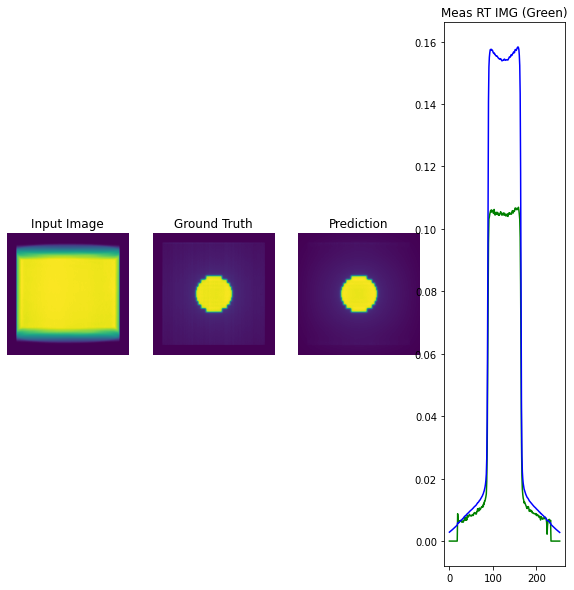

In [ ]:
for example in train_dataset.take(1):
  input = example['input']
  print(tf.shape(input))
  rtimg = example['rtimg']
  #rtimg = tf.squeeze(rtimg, axis=0)
  generate_images(generator, input, rtimg)

In [ ]:
generator.layers[-2].weights

Test the generator:

### Define the generator loss

GANs learn a loss that adapts to the data, while cGANs learn a structured loss that penalizes a possible structure that differs from the network output and the target image, as described in the [pix2pix paper](https://arxiv.org/abs/1611.07004).

- The generator loss is a sigmoid cross-entropy loss of the generated images and an **array of ones**.
- The pix2pix paper also mentions the L1 loss, which is a MAE (mean absolute error) between the generated image and the target image.
- This allows the generated image to become structurally similar to the target image.
- The formula to calculate the total generator loss is `gan_loss + LAMBDA * l1_loss`, where `LAMBDA = 100`. This value was decided by the authors of the paper.

## Define the optimizers and a checkpoint-saver


In [ ]:
def generate_images(model, input, tar):
  
  # inp = tf.squeeze(input,axis=0)
  # inCT = inp[:,:,0]
  # inPDOS = inp[:,:,2]
  # input =[inCT[tf.newaxis, ...],inPDOS[tf.newaxis, ...]]
  
  # prediction = model(inputs=[inCT[tf.newaxis, ...],inPDOS[tf.newaxis, ...]], training=True)
  prediction = model(input, training=False)
  plt.figure(figsize=(10, 10))

  # print("Input ")
  # print(type(cbct_input))
  # print(tf.shape(cbct_input))
  # print("ground truth")
  # print(type(tar))
  # print(tf.shape(tar))
  display_list = [input[0], tar[0], prediction[0]]
  title = ['Input CBCT Image', 'Ground Truth', 'Predicted Image']
  
  plt.subplot(1, 4, 1)
  plt.title('Input Image')
  # Getting the pixel values in the [0, 1] range to plot.
  
  input = tf.squeeze(input,axis=0)
  inslice = getinput(input,1)
  
  plt.imshow(inslice)
  plt.axis('off')
  plt.subplot(1, 4, 2)
  plt.title('Ground Truth')
  # Getting the pixel values in the [0, 1] range to plot.
  #plt.imshow(tf.squeeze(tar[0],axis=0))
  #tar = tf.cast(tar,tf.float32)
  plt.imshow(tf.squeeze(tar[0],axis=-1))
  plt.axis('off')
  plt.subplot(1, 4, 3)

  plt.title('Prediction')
  # Getting the pixel values in the [0, 1] range to plot.
  #plt.imshow(tf.squeeze(tar[0],axis=0))
  #tar = tf.cast(tar,tf.float32)
  plt.imshow(tf.squeeze(prediction[0],axis=-1))
  plt.axis('off')
  
  
  plt.subplot(1, 4, 4)
  plt.title('Predicted Image')
  
  tar = tf.squeeze(tar, axis=0)
  tar = tf.squeeze(tar, axis=-1)
  prediction = tf.squeeze(prediction, axis=0)
  prediction = tf.squeeze(prediction, axis=-1)
  
  predvec = prediction[128,1:256]
  rtvec = tar[128,1:256]
  
  #predvec = prediction[1:256,128]
  #rtvec = tar[1:256,128]


  plt.plot(rtvec,'g')
  plt.title("Meas RT IMG (Green)")
  plt.plot(predvec,'b')

  # Getting the pixel values in the [0, 1] range to plot.
  #print(tf.shape(prediction))
  #prediction = tf.cast(prediction,tf.float32)
  #plt.imshow(tf.squeeze(prediction[0],axis=-1))
  #plt.axis('off')
  
  plt.show()

Test the function:

In [ ]:
from tensorflow.python.ops import math_ops
class CustomMeanSquareError(tf.keras.losses.Loss):
  def call(self, y_true, y_pred):
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)
    return tf.reduce_mean(math_ops.square(y_pred - y_true), axis=-1)
class CustomMultSquareError(tf.keras.losses.Loss):
  def call(self, y_true, y_pred):
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)
    return tf.reduce_mean(tf.abs(y_pred - y_true) * tf.abs(y_true), axis=-1)

class CustomWeigthed(tf.keras.losses.Loss):
  def call(self, y_true, y_pred):
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)
    w = 0.01
    tar_bkg = tf.where(tf.less_equal(y_true,0.05), y_true,0.0)
    gen_bkg = tf.where(tf.less_equal(y_true,0.05),y_pred,0.0)

    target_vals = tf.where(tf.greater(y_true,0.05),y_true,0.0)
    gen_vals = tf.where(tf.greater(y_true,0.05),y_pred,0.0)

    return w*tf.reduce_mean(tf.abs(tar_bkg - gen_bkg)) + tf.reduce_mean(tf.abs(target_vals - gen_vals))
    

In [ ]:
mae = tf.keras.metrics.MeanAbsoluteError()
mae_loss = tf.keras.losses.MeanAbsoluteError()
#mae_loss = CustomWeigthed() 

In [ ]:
epochs = 31
train_gen = data_generators['train']
val_gen = data_generators['validation']
dilation_kernel = 3
scatter = True
add_half = False
for kernel in [16]:
  for dil_rate in [3]:
    for lr in [5.0521e-4]:
      # early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=30)
      #generator = Generator(include_scatter=scatter, kernel=kernel, half_kernel=half_kernel, dilation_rate=dil_rate, add_half=add_half)
      generator = GeneratorCB2()
      #generator = GeneratorU2(size=3, layers=3, filters_start=4, double_layers=4, pool_size=2)
      #tensorboard_output = "/content/drive/MyDrive/Colab Notebooks/logs_CB/CBphan_pdoskernal{}_kernel_{}_lr{}_epoch{}_addhalf{}".format(scatter, kernel, lr,epochs,add_half)
      #tensorboard_output = "/content/drive/MyDrive/Colab Notebooks/logs_CB/Uphan{}_kernel_{}_lr{}_epoch{}_addhalf{}".format(scatter, kernel, lr,epochs,add_half)
      tensorboard_output = "/content/drive/MyDrive/Colab Notebooks/logs_CB/CB2gausbkg_large_lr{}_epoch{}".format(lr,epochs)
      print(tensorboard_output)
      if not os.path.exists(tensorboard_output):
        os.makedirs(tensorboard_output)
      else:
        continue
      tensorboard = tf.keras.callbacks.TensorBoard(log_dir=tensorboard_output,
                                                    profile_batch=0,
                                                    write_graph=False)
      generator.compile(optimizer=tf.keras.optimizers.Adam(lr, beta_1=0.5),
                        loss=mae_loss, metrics=[mae])
      generator.fit(train_gen.data_set, steps_per_epoch=len(train_gen),
                    validation_data=val_gen.data_set, epochs=epochs, validation_freq=5,
                    validation_steps=len(val_gen), callbacks=[tensorboard])
      generator.save(os.path.join(tensorboard_output, 'final_model.h5'))

/content/drive/MyDrive/Colab Notebooks/logs_CB/CB2gausbkg_large_lr0.00050521_epoch31
Epoch 1/31
30/30 [==============================] - 2s 17ms/step - loss: 0.0050 - mean_absolute_error: 0.0038
Epoch 2/31
30/30 [==============================] - 0s 15ms/step - loss: 0.0041 - mean_absolute_error: 0.0041
Epoch 3/31
30/30 [==============================] - 0s 14ms/step - loss: 0.0044 - mean_absolute_error: 0.0044
Epoch 4/31
30/30 [==============================] - 0s 15ms/step - loss: 0.0040 - mean_absolute_error: 0.0040
Epoch 5/31
30/30 [==============================] - 1s 50ms/step - loss: 0.0038 - mean_absolute_error: 0.0038 - val_loss: 0.0032 - val_mean_absolute_error: 0.0032
Epoch 6/31
30/30 [==============================] - 0s 15ms/step - loss: 0.0033 - mean_absolute_error: 0.0033
Epoch 7/31
30/30 [==============================] - 0s 14ms/step - loss: 0.0031 - mean_absolute_error: 0.0031
Epoch 8/31
30/30 [==============================] - 0s 14ms/step - loss: 0.0033 - mean_absol

## Training

- For each example input generates an output.
- The discriminator receives the `input_image` and the generated image as the first input. The second input is the `input_image` and the `target_image`.
- Next, calculate the generator and the discriminator loss.
- Then, calculate the gradients of loss with respect to both the generator and the discriminator variables(inputs) and apply those to the optimizer.
- Finally, log the losses to TensorBoard.

Finally, run the training loop:

In [ ]:
generator.layers[-1].weights

In [ ]:
%reload_ext tensorboard

In [ ]:
#docs_infra: no_execute'

%tensorboard --logdir '/content/drive/MyDrive/Colab Notebooks/logs_CB/'

If you want to share the TensorBoard results _publicly_, you can upload the logs to [TensorBoard.dev](https://tensorboard.dev/) by copying the following into a code-cell.

Note: This requires a Google account.

```
!tensorboard dev upload --logdir {log_dir}
```

Caution: This command does not terminate. It's designed to continuously upload the results of long-running experiments. Once your data is uploaded you need to stop it using the "interrupt execution" option in your notebook tool.

You can view the [results of a previous run](https://tensorboard.dev/experiment/lZ0C6FONROaUMfjYkVyJqw) of this notebook on [TensorBoard.dev](https://tensorboard.dev/).

TensorBoard.dev is a managed experience for hosting, tracking, and sharing ML experiments with everyone.

It can also included inline using an `<iframe>`:

In [ ]:
# display.IFrame(
#     src="https://tensorboard.dev/experiment/lZ0C6FONROaUMfjYkVyJqw",
#     width="100%",
#     height="1000px")

Interpreting the logs is more subtle when training a GAN (or a cGAN like pix2pix) compared to a simple classification or regression model. Things to look for:

- Check that neither the generator nor the discriminator model has "won". If either the `gen_gan_loss` or the `disc_loss` gets very low, it's an indicator that this model is dominating the other, and you are not successfully training the combined model.
- The value `log(2) = 0.69` is a good reference point for these losses, as it indicates a perplexity of 2 - the discriminator is, on average, equally uncertain about the two options.
- For the `disc_loss`, a value below `0.69` means the discriminator is doing better than random on the combined set of real and generated images.
- For the `gen_gan_loss`, a value below `0.69` means the generator is doing better than random at fooling the discriminator.
- As training progresses, the `gen_l1_loss` should go down.

## Restore the latest checkpoint and test the network

In [ ]:
#os.listdir(checkpoint_dir)
#os.listdir(log_dir + '/fit')

In [ ]:
#Restoring the latest checkpoint in checkpoint_dir
#checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Generate some images using the test set

In [ ]:
#generator.save('/content/drive/MyDrive/Colab Notebooks/cb_models/GEN_relu_2k_fold1.h5')

In [ ]:
os.listdir('/content/drive/MyDrive/Colab Notebooks/logs_CB/')

In [ ]:
generator = GeneratorU()
#generator = GeneratorCB()
generator.load_weights(r'/content/drive/MyDrive/Colab Notebooks/logs_CB/U5_fil4_kern_16_phan_lr0.00050521_epoch51/final_model.h5')

In [ ]:
gamma_options = {
    'dose_percent_threshold': 3,  # Try with 2%/2mm 
    'distance_mm_threshold': 3,
    'lower_percent_dose_cutoff': 10,
    'interp_fraction': 20,  # Should be 10 or more, see the paper referenced above
    'max_gamma': 2,
    'random_subset': None,  # Can be used to get quick pass rates
    'local_gamma': False,  # Change to false for global gamma
    'ram_available': 2**29  # 1/2 GB
}

In [ ]:
xepidmin = -256
xepidmax = 256
yepidmin = -256
yepidmax = 256
grid = 2
xepid = np.arange(xepidmin,xepidmax,grid)
yepid = np.arange(yepidmin,yepidmax,grid)
coords = (yepid,xepid)

In [ ]:
train_test, valid_test = return_fold_datasets(data_generators, batch_size=1)

tf.Tensor([  1 256 256   3], shape=(4,), dtype=int32)
Calcing using global normalisation point for gamma
Global normalisation set to 0.12581036984920502
Global dose threshold set to [0.00377431] ([3]% of normalisation)
Distance threshold set to [3]
Lower dose cutoff set to 0.012581036984920503 (10% of normalisation)

Current distance: 5.85 mm | Number of reference points remaining: 6158 | Points tested per reference point: 247 | RAM split count: 1
Complete!


Text(0.5, 1.0, 'Local Gamma (3%/3mm) | Percent Pass: 74.60 %')

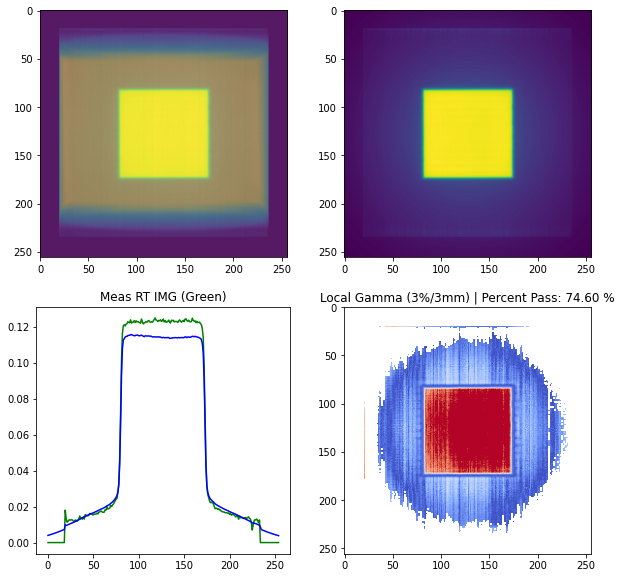

In [ ]:
example = next(iter(valid_dataset))
#example = next(iter(train_dataset))

input = example['input']
print(tf.shape(input))
tar = example['rtimg']
prediction = generator(input, training=False) 
#prediction = generator(input)


tar = tf.squeeze(tar, axis=0)
tar = tf.squeeze(tar, axis=-1)
rtimage = tar


prediction = tf.squeeze(prediction, axis=0)
prediction = tf.squeeze(prediction, axis=-1)
prediction = prediction 

inp = tf.squeeze(input,axis=0)
inslice = getinput(inp,1)

plt.figure(figsize=(10, 10))
  
plt.subplot(2, 2, 1)
plt.imshow(inslice,alpha=0.8) 
plt.imshow(rtimage,alpha=0.5)
plt.subplot(2, 2, 2)
plt.imshow(prediction)
  
predvec = prediction[128,1:256]
rtvec = rtimage[128,1:256]
  
#predvec = prediction[1:256,128]
#rtvec = rtimage[1:256,128]

plt.subplot(2, 2, 3)
plt.plot(rtvec,'g')
plt.title("Meas RT IMG (Green)")
plt.plot(predvec,'b')
#print(str(example["fname"]))

gamma_test = pymedphys.gamma(coords,rtimage, coords, prediction, **gamma_options)
valid_gamma = gamma_test[~np.isnan(gamma_test)]

num_bins = (
    gamma_options['interp_fraction'] * gamma_options['max_gamma'])
bins = np.linspace(0, gamma_options['max_gamma'], num_bins + 1)

#gamma_no_noise = pymedphys.gamma(coords, rtimage, coords, prediction,**gamma_options)
plt.subplot(2, 2, 4)

plt.imshow( gamma_test, clim=(0, 2), cmap='coolwarm')

# plt.hist(valid_gamma, bins, density=True)
# plt.xlim([0, gamma_options['max_gamma']])
pass_ratio = np.sum(valid_gamma <= 1) / len(valid_gamma)
plt.title(f"Local Gamma ({gamma_options['dose_percent_threshold']}%/{gamma_options['distance_mm_threshold']}mm) | Percent Pass: {pass_ratio*100:.2f} %")

In [ ]:
plt.imshow(gamma_test)

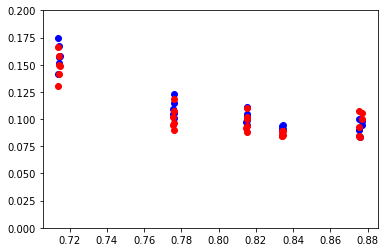

In [ ]:

caxcb = [] 
caxrt = []
caxpred = []
caxhalf = []

all_ratios = np.zeros(len(list(train_dataset)))
i = 0
i90 =0
for example in train_dataset:
  tinp = example['input']
  ttar = example['rtimg']
  inp = tf.squeeze(tinp,axis=0)
  #slicen = 1
  pdos = getinput(inp,0)
  img = getinput(inp,1)
  half = getinput(inp,2)
  cbctcax = np.mean(img[126:130,126:130] )
  pdoscax = np.mean(pdos[126:130,126:130] )
  halfcax = np.mean(half[126:130,126:130] )
  prediction = generator(tinp, training=False)
  ttar = tf.squeeze(ttar, axis=0)
  ttar = tf.squeeze(ttar, axis=-1)
  rtimage = ttar
  rtcax = np.mean(ttar[126:130,126:130])
  
  #out = "cbctcax {} rtcax {}".format(cbctcax,rtcax/pdoscax)
  #print(out)
  prediction = tf.squeeze(prediction, axis=0)
  prediction = tf.squeeze(prediction, axis=-1)
  predcax = np.mean(prediction[126:130,126:130])
  caxcb = np.append(caxcb,cbctcax)
  caxrt = np.append(caxrt,rtcax/pdoscax)
  caxpred = np.append(caxpred,predcax/pdoscax)
  caxhalf = np.append(caxhalf,halfcax)

#ax = plt.axes(projection='3d')
#ax.scatter3D(caxcb, caxhalf, caxrt, c='b' )
#ax.scatter3D(caxcb, caxhalf, caxpred, c='r' )
#plt.show()

plt.plot(caxcb,caxrt,'bo')
plt.plot(caxcb,caxpred,'ro')

#plt.plot(caxhalf,caxrt,'bo')
#plt.plot(caxhalf,caxpred,'ro')
plt.ylim([0, 0.2])
#plt.xlim([0.80, 0.85])
plt.show()

In [ ]:
all_ratios = np.zeros(len(list(valid_dataset)))
i = 0
i90 =0
for example in valid_dataset:
  tinp = example['input']
  ttar = example['rtimg']
  prediction = generator(tinp, training=False)
  ttar = tf.squeeze(ttar, axis=0)
  ttar = tf.squeeze(ttar, axis=-1)
  rtimage = ttar

  prediction = tf.squeeze(prediction, axis=0)
  prediction = tf.squeeze(prediction, axis=-1)
  prediction = prediction
  gamma_test = pymedphys.gamma(coords,rtimage, coords, prediction, **gamma_options,quiet=True)
  valid_gamma = gamma_test[~np.isnan(gamma_test)]
  pass_ratio = np.sum(valid_gamma <= 1) / len(valid_gamma)
  #tf.print(example["fname"])
  print(pass_ratio)
  all_ratios[i] = pass_ratio
  i = i+1
  if(pass_ratio> 0.90):
    i90 = i90+1

print("mean " + str(np.mean(all_ratios)))
print("STD " + str(np.std(all_ratios)))
print("max " + str(np.max(all_ratios)))
print("min " + str(np.min(all_ratios))) 
print("fraction > 90% " + str(i90) + " total " + str(i))
plt.hist(all_ratios)

In [ ]:
generator.summary()

In [ ]:
arr =generator.layers[-5].weights

In [ ]:
arr = tf.squeeze(arr[0],axis=-1)
#arr = tf.squeeze(arr[0],axis=-1)